In [1]:
%matplotlib inline

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [11]:
def kl_divergence(p, p_hat, eps=1e-7):
    p_0 = tf.clip_by_value(p, eps, 1)
    p_1 = tf.clip_by_value(1-p, eps, 1)
    p_hat_0 = tf.clip_by_value(p_hat, eps, 1)
    p_hat_1 = tf.clip_by_value(1 - p_hat, eps, 1)
    
    res = p_0 * (tf.log(p_0) - tf.log(p_hat_0)) + \
           p_1 * (tf.log(p_1) - tf.log(p_hat_1))
    res = tf.reduce_mean(res)
    return res

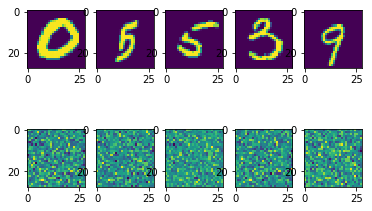

step     0, loss 0.2308, kld_loss 0.9798, total_loss 0.2788


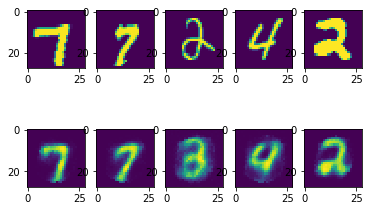

step  2000, loss 0.0306, kld_loss 10.8639, total_loss 0.5808


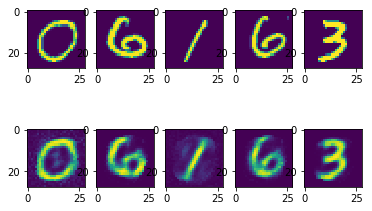

step  4000, loss 0.0229, kld_loss 10.2009, total_loss 0.5317


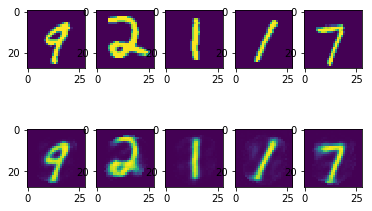

step  6000, loss 0.0144, kld_loss 11.1063, total_loss 0.5673


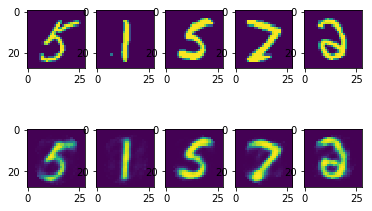

step  8000, loss 0.0143, kld_loss 11.9139, total_loss 0.6078


In [52]:
with tf.Graph().as_default() as g:
    inputs = tf.placeholder(shape=[None, 784], dtype=tf.float32)
    labels = tf.placeholder(shape=[None, 10], dtype=tf.float32)
    hidden = tf.keras.layers.Dense(64, activation=tf.nn.relu)(inputs)
    output = tf.keras.layers.Dense(784, activation=tf.nn.sigmoid)(hidden)
    
    loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(inputs, output))
    kld_loss = kl_divergence(0.10, hidden)
    total_loss = loss + kld_loss * 0.05
    
    acc = tf.reduce_mean(
        tf.cast(tf.equal(tf.argmax(labels, axis=1), tf.argmax(output, axis=1)),
                tf.float32))
    

    
with tf.Session(graph=g) as sess:
    optim = tf.train.GradientDescentOptimizer(learning_rate=2.5)
#     optim = tf.train.MomentumOptimizer(learning_rate=0.01)
    tran_op = optim.minimize(loss)  #最小化代价
    sess.run(tf.global_variables_initializer())
    
    for i in range(10000):
        batch_img, _ = mnist.train.next_batch(32)
        
        res_loss, _ = sess.run(
            [loss, tran_op],
            feed_dict={inputs: batch_img})
        if i % 2000 == 0:
            batch_img, _ = mnist.test.next_batch(5)
            
            res_out = sess.run(
                output, feed_dict={inputs: batch_img})
            for j in range(10):
                plt.subplot(2, 5, j+1)
                img = batch_img[j] if j < 5 else res_out[j - 5]

                img = ((img * 255).astype(np.uint8).reshape([28, 28]))
                plt.imshow(img)
            plt.show()    
#             print(res_loss)
            res_total_loss = sess.run(total_loss, feed_dict={
                    inputs: batch_img
                })
            res_kld_loss = sess.run(kld_loss, feed_dict={
                    inputs: batch_img
                })
            print('step %5d, loss %2.4f, kld_loss %2.4f, total_loss %2.4f' % (i, res_loss, res_kld_loss, res_total_loss))